# **Importing data for model training**

In [ ]:
from datasets import load_dataset    

# Stream the dataset to ensure no memory constraints   
dataset = load_dataset("wikipedia", "20220301.en", split='train', streaming=True)    

# Take a sample from the streamed dataset    
sampled_dataset = dataset.take(100)  # About 1.2GB of data   

# Printing the first few samples to check    

for sample in sampled_dataset:    

    print(sample) 

    break 

In [ ]:
# Defining the path for the output text file    

output_file_path = 'wikipedia_subset.txt'    

# Open the output file in write mode    

with open(output_file_path, 'w', encoding='utf-8') as file:    

    for sample in dataset.take(50000):  # the number of samples     

        # writing the article title followed by its text.      


        file.write(sample['title'] + '\n')  # Write the article title    

  

        file.write(sample['text'] + '\n')   # Write the article text    

  

        file.write('\n')  # adding a extra newline for separation between articles    

In [ ]:
# the path for your input text file    

input_file_path = 'wikipedia_subset.txt'     

number_of_articles_to_print = 10 

# Open the input file in read mode    

with open(input_file_path, 'r', encoding='utf-8') as file:    

    article_count = 0    

    article_text = ""    

    for line in file:    

        if line.strip() == "":  # Using an empty line is used to separate articles    

            article_count += 1    

            print(f"Article {article_count}:\n{article_text}\n")    

            article_text = ""  # Reseting for the next article    

            if article_count >= number_of_articles_to_print:    

                break    

        else:    

            article_text += line  # Putting together lines for a single article    

# If fewer articles were found than expected    
  
if article_count < number_of_articles_to_print:    

    print(f"Only {article_count} articles were found in the file.") 

In [ ]:
with open('first_lines_200kb.txt', 'r', encoding='utf-8') as file:    

    raw_text = file.read() 

# **Import and Split data for testing**

In [ ]:
from datasets import load_dataset  
import random  
  
# Specify the path for the output text file  
output_file_path = 'wikipedia_random_testing1.txt'  
  
# Stream the dataset to ensure no memory constraints, using the 'test' split  
dataset = load_dataset("wikipedia", "20220301.en", split='train', streaming=True)  
  
# Fetch a specific number of articles (e.g., 100) from the streamed dataset  
num_articles_to_fetch = 10
articles = []  
for i, sample in enumerate(dataset):  
    articles.append(sample)  
    if i + 1 == num_articles_to_fetch:  
        break  
  
# Randomly choose one article from the fetched articles  
random_article = random.choice(articles)  
  
# Print the randomly chosen article to check  
print(random_article)  
  
# Save the randomly chosen article to a file  
with open(output_file_path, 'w', encoding='utf-8') as file:  
    # Write the article title  
    file.write(random_article['title'] + '\n\n')  
    # Write the article text  
    file.write(random_article['text'] + '\n')  

In [ ]:
# Specify the path for the output text file  
output_file_path = 'wikipedia_random_testing1.txt'  
  
# Open the file in read mode and print its contents  
with open(output_file_path, 'r', encoding='utf-8') as file:  
    contents = file.read()  
    print(contents)  


# **Cleaning and Pre-processing the data**

In [ ]:
import re 

# Pre-processing the data    

cleaned_text = re.sub(r'\[.*?\]', '', raw_text)  # Remove text within brackets     

cleaned_text = re.sub(r'http\S+', '', cleaned_text)  # Remove URLs    



In [ ]:
cleaned_text = cleaned_text.lower()  # Convert to lowercase 

In [ ]:
# Specifing the path for the cleaned data file    

cleaned_file_path = 'wikipedia_subset_cleaned.txt'    

# Writing the cleaned text to a new file    

with open(cleaned_file_path, 'w', encoding='utf-8') as file:    

    file.write(cleaned_text) 

In [ ]:
def split_file_by_characters(original_file, chars_per_file=300000000):    

    """Split a file into multiple smaller files with a specified number of characters."""    

    with open(original_file, 'r', encoding='utf-8') as big_file:    

        content = big_file.read()    
  
    total_chars = len(content)    

    num_files = total_chars // chars_per_file + (1 if total_chars % chars_per_file else 0)      

    for i in range(num_files):    

        start_index = i * chars_per_file    

        end_index = start_index + chars_per_file    

        small_content = content[start_index:end_index]      

        small_filename = f'subset_char_{i}.txt'    

        with open(small_filename, 'w', encoding='utf-8') as small_file:    

            small_file.write(small_content)    

# To reduce the size of the files, and use for training    

split_file_by_characters('wikipedia_subset.txt', chars_per_file=300000000)    

In [ ]:
# Specify the path to the cleaned file  
cleaned_file_path = 'wikipedia_subset_cleaned.txt'  
  
# Open the cleaned file for reading  
with open(cleaned_file_path, 'r', encoding='utf-8') as file:  
    # Read the first few lines from the file  
    for _ in range(5):  # Adjust the number 5 if you want more or fewer lines  
        line = file.readline()  
        print(line.strip())  # Print each line, removing any extra whitespace  


# **Start the Run for the code here:**

In [1]:
# All import functions go here
import torch 
from transformers import GPT2Tokenizer  
from torch.utils.data import Dataset, DataLoader  
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader  
import torch.nn as nn    
import torch.nn.functional as F
from transformers import GPT2Tokenizer, GPT2LMHeadModel  
import csv  

/anaconda/envs/azureml_py38_PT_TF/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
  
# Initialize the tokenizer  
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")  
  
# Adding special tokens for padding and unknown tokens  
tokenizer.add_special_tokens({'pad_token': '<pad>', 'unk_token': '<unk>'})  
  
# Define the path to your dataset before using it  
file_path = 'wikipedia_subset_cleaned.txt'  
  
def tokenize_and_split_dataset_gpt2(file_path, tokenizer, max_length=1024):  
    tokenized_data = []  
    with open(file_path, 'r', encoding='utf-8') as file:  
        for line in file:  
            # Encode the line  
            encoded_line = tokenizer.encode(line.strip(), add_special_tokens=True)  
            # If the encoded line is longer than max_length, split it into chunks.
            # This ensures the embeddings are of the right size
            for i in range(0, len(encoded_line), max_length):  
                chunk = encoded_line[i:i+max_length]  
                tokenized_data.append(chunk)  
    return tokenized_data  
  
# Tokenize the dataset with the defined tokenizer and split long sequences  
tokenized_data_gpt2 = tokenize_and_split_dataset_gpt2(file_path, tokenizer)  
  
def save_tokenized_data_gpt2(tokenized_data, output_file='tokenized_data_gpt2.txt'):  
    with open(output_file, 'w', encoding='utf-8') as file:  
        for chunk in tokenized_data:  
            # Convert each token ID in the chunk to a string and join them with a space  
            chunk_str = ' '.join(str(token_id) for token_id in chunk)  
            file.write(chunk_str + '\n')  
  
# Save the tokenized and split data  
save_tokenized_data_gpt2(tokenized_data_gpt2)  


In [5]:
  
class GPT2Dataset(Dataset):  
    def __init__(self, filename, tokenizer, max_length):  
        self.tokenizer = tokenizer  
        self.max_length = max_length  
        self.tokens = []  
        with open(filename, 'r', encoding='utf-8') as file:  
            for line in file:  
                token_ids = [int(token_id) for token_id in line.strip().split()]  
                self.tokens.append(token_ids)  
                  
    def __len__(self):  
        return len(self.tokens)  
      
    def __getitem__(self, idx):  
        token_ids = self.tokens[idx]  
        # Ensure the sequence is within max_length  
        token_ids = token_ids[:self.max_length]  
        # Create tensors  
        input_ids = torch.tensor(token_ids[:-1], dtype=torch.long)  
        targets = torch.tensor(token_ids[1:], dtype=torch.long)  
        return input_ids, targets  


In [6]:
if tokenizer.pad_token is None:  
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})  
pad_token_id = tokenizer.pad_token_id  


In [7]:
  
def collate_batch(batch):  
    input_ids, target_ids = zip(*batch)  
    if tokenizer.pad_token is None:  
        tokenizer.add_special_tokens({'pad_token': '[PAD]'})  
    pad_token_id = tokenizer.pad_token_id  
      
    input_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids],  
                                    batch_first=True, padding_value=pad_token_id)  
    target_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in target_ids],  
                                     batch_first=True, padding_value=pad_token_id)  
    print("Input IDs Padded Shape:", input_ids_padded.shape)  
    print("Target IDs Padded Shape:", target_ids_padded.shape)  
      
    return input_ids_padded, target_ids_padded  
 

# Initialize the dataset  
dataset = GPT2Dataset('tokenized_data_gpt2.txt', tokenizer, max_length=1024)  
  
# Creating the DataLoader  
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)  


In [8]:

# verifying batches have been created
print("Number of batches:", len(dataloader))  


Number of batches: 23


In [9]:
# Manually checking code by create a batch by selecting a few items of the dataset  

sample_batch = [dataset[i] for i in range(4)]  # This will provide the first 4 shapes 

# Manually calling the defined collate_batch function with this sample batch  
input_ids_padded, target_ids_padded = collate_batch(sample_batch)  
  
# Check the shapes  
print("Input IDs Padded Shape:", input_ids_padded.shape)  
print("Target IDs Padded Shape:", target_ids_padded.shape)  


Input IDs Padded Shape: torch.Size([4, 168])
Target IDs Padded Shape: torch.Size([4, 168])
Input IDs Padded Shape: torch.Size([4, 168])
Target IDs Padded Shape: torch.Size([4, 168])


/tmp/ipykernel_4198/2817920276.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids],
/tmp/ipykernel_4198/2817920276.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in target_ids],


In [10]:
    
class MultiHeadSelfAttention(nn.Module):    
    def __init__(self, embed_size, heads):    
        super(MultiHeadSelfAttention, self).__init__()    
        self.embed_size = embed_size    
        self.heads = heads    
        self.head_dim = embed_size // heads    
    
        assert (    
            self.head_dim * heads == embed_size    
        ), "Embedding size needs to be divisible by heads"    
    
        self.values = nn.Linear(embed_size, embed_size, bias=False)  # Adjusted to embed_size  
        self.keys = nn.Linear(embed_size, embed_size, bias=False)    # Adjusted to embed_size  
        self.queries = nn.Linear(embed_size, embed_size, bias=False) # Adjusted to embed_size  
        self.fc_out = nn.Linear(heads * self.head_dim, embed_size)    
    
    def forward(self, values, keys, query, mask):    
        N = query.shape[0]    
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]    
  
        # Apply the linear transformations first, before splitting into heads  
        values = self.values(values)    
        keys = self.keys(keys)    
        queries = self.queries(query)    
  
        # Then split the embeddings into self.heads different pieces  
        values = values.reshape(N, value_len, self.heads, self.head_dim)    
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)    
        queries = queries.reshape(N, query_len, self.heads, self.head_dim)    
  
        # Attention mechanism  
        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])    
        if mask is not None:    
            energy = energy.masked_fill(mask == 0, float("-1e20"))    
    
        attention = torch.softmax(energy / (self.head_dim ** (1 / 2)), dim=3)  # Corrected scaling factor  
    
        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(    
            N, query_len, self.heads * self.head_dim    
        )    
    
        out = self.fc_out(out)    
        return out  


In [11]:
class TransformerBlock(nn.Module):  
    def __init__(self, embed_size, heads, dropout, forward_expansion):  
        super(TransformerBlock, self).__init__()  
        self.attention = MultiHeadSelfAttention(embed_size, heads)  
        self.norm1 = nn.LayerNorm(embed_size)  
        self.norm2 = nn.LayerNorm(embed_size)  
  
        self.feed_forward = nn.Sequential(  
            nn.Linear(embed_size, forward_expansion * embed_size),  
            nn.ReLU(),  
            nn.Linear(forward_expansion * embed_size, embed_size),  
        )  
  
        self.dropout = nn.Dropout(dropout)  
  
    def forward(self, value, key, query, mask):  
        attention = self.attention(value, key, query, mask)  
  
        # Add skip connection, followed by layer normalization  
        x = self.dropout(self.norm1(attention + query))  
        forward = self.feed_forward(x)  
          
        # Second skip connection and layer normalization  
        out = self.dropout(self.norm2(forward + x))  
        return out  


In [12]:
class GPT(nn.Module):      
    def __init__(self, vocab_size, embed_size, num_layers, heads, forward_expansion, dropout, max_length):      
        super(GPT, self).__init__()      
        self.vocab_size = vocab_size  # Ensure this line is present  
        self.embed_size = embed_size      
        self.word_embedding = nn.Embedding(vocab_size, embed_size)      
        self.position_embedding = nn.Embedding(max_length, embed_size)      
      
        self.layers = nn.ModuleList(      
            [TransformerBlock(embed_size, heads, dropout=dropout, forward_expansion=forward_expansion)      
             for _ in range(num_layers)]      
        )      
      
        self.dropout = nn.Dropout(dropout)      
        self.fc_out = nn.Linear(embed_size, vocab_size)      
      
    def forward(self, x, mask=None):      
        N, seq_length = x.shape      
        positions = torch.arange(0, seq_length, device=x.device).expand(N, seq_length)      
      
        out = self.dropout(self.word_embedding(x) + self.position_embedding(positions))      
      
        for layer in self.layers:      
            out = layer(out, out, out, mask)      
      
        out = self.fc_out(out)      
        return out    


In [13]:
# As we are using Azure, it will use the compute that has been set up but good practise to check for GPU

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
  

In [14]:
# Initialising the model  

# Outlining the layers of the model

model = GPT(vocab_size=60000, embed_size=128, num_layers=6, heads=8, forward_expansion=4, dropout=0.1, max_length=1024)    

In [15]:
# Mapping out the model I have put together for the compute

model.to(device)  

GPT(
  (word_embedding): Embedding(60000, 128)
  (position_embedding): Embedding(1024, 128)
  (layers): ModuleList(
    (0): TransformerBlock(
      (attention): MultiHeadSelfAttention(
        (values): Linear(in_features=128, out_features=128, bias=False)
        (keys): Linear(in_features=128, out_features=128, bias=False)
        (queries): Linear(in_features=128, out_features=128, bias=False)
        (fc_out): Linear(in_features=128, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (feed_forward): Sequential(
        (0): Linear(in_features=128, out_features=512, bias=True)
        (1): ReLU()
        (2): Linear(in_features=512, out_features=128, bias=True)
      )
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attention): MultiHeadSelfAttention(
        (values): Linear(in_features=128, out_features=128, bias=

In [16]:
# defining the training of the GPT model

def train(model, dataloader, optimizer, criterion, device):  
    model.train()  
    total_loss = 0  
    for batch_idx, (input_ids, targets) in enumerate(dataloader):  
        input_ids, targets = input_ids.to(device), targets.to(device)  
  
        optimizer.zero_grad()  
        output = model(input_ids)  
        loss = criterion(output.view(-1, model.vocab_size), targets.view(-1))  
        loss.backward()  
        optimizer.step()  
  
        total_loss += loss.item()  
    return total_loss / len(dataloader)  
 


In [17]:

# checking if the tensor sizes are valid

print(dataset[0])  


(tensor([272, 998]), tensor([ 998, 1042]))


In [18]:
import torch.optim as optim    
  
# Model, GPT2Dataset, and DataLoader are correctly defined and initialized already  
  
# Targeting the available device  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    
model.to(device)    
    
# Define the optimizer and the loss function  
optimizer = optim.Adam(model.parameters())    
criterion = torch.nn.CrossEntropyLoss()    
  
# Initialise the custom dataset and DataLoader here

# Adjust 'max_length' and 'batch_size' as per the specific requirements based on the model layers

# Initialize my custom dataset with the tokenizer  
dataset = GPT2Dataset('tokenized_data_gpt2.txt', tokenizer, max_length=1024)  # Pass the tokenizer here  
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=collate_batch)  
  
num_epochs = 5  # Number of epochs  
  
for epoch in range(num_epochs):  
    model.train()  # Ensure the model is in training mode  
    total_loss = 0  
    total_batches = len(dataloader)  
      
    for input_ids, target_ids in dataloader:  
        input_ids, target_ids = input_ids.to(device), target_ids.to(device)  # Move data to the appropriate device  
  
        optimizer.zero_grad()  # Clear gradients  
        output = model(input_ids)  # Forward pass  
        loss = criterion(output.view(-1, output.size(-1)), target_ids.view(-1))  # Compute loss  
        loss.backward()  # Backward pass  
        optimizer.step()  # Update model parameters  
  
        total_loss += loss.item()  # Accumulate loss  
  
    avg_loss = total_loss / total_batches  # Calculate average loss for the epoch  
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")  


Input IDs Padded Shape: torch.Size([32, 155])
Target IDs Padded Shape: torch.Size([32, 155])
Input IDs Padded Shape: torch.Size([32, 168])
Target IDs Padded Shape: torch.Size([32, 168])
Input IDs Padded Shape: torch.Size([32, 245])
Target IDs Padded Shape: torch.Size([32, 245])
Input IDs Padded Shape: torch.Size([32, 275])
Target IDs Padded Shape: torch.Size([32, 275])
Input IDs Padded Shape: torch.Size([32, 246])
Target IDs Padded Shape: torch.Size([32, 246])
Input IDs Padded Shape: torch.Size([32, 199])
Target IDs Padded Shape: torch.Size([32, 199])
Input IDs Padded Shape: torch.Size([32, 251])
Target IDs Padded Shape: torch.Size([32, 251])
Input IDs Padded Shape: torch.Size([32, 153])
Target IDs Padded Shape: torch.Size([32, 153])
Input IDs Padded Shape: torch.Size([32, 274])
Target IDs Padded Shape: torch.Size([32, 274])
Input IDs Padded Shape: torch.Size([32, 266])
Target IDs Padded Shape: torch.Size([32, 266])
Input IDs Padded Shape: torch.Size([32, 157])
Target IDs Padded Shape:

/tmp/ipykernel_4198/2817920276.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids],
/tmp/ipykernel_4198/2817920276.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in target_ids],


In [19]:
import torch  
import math  
from torch.nn.functional import cross_entropy  
  
def calculate_perplexity(model, dataloader, device):  
    model.eval()  # Set the model to evaluation mode  
    total_loss = 0  
    total_tokens = 0  # Keep track of the total number of tokens processed  
  
    with torch.no_grad():  # No need to compute gradients  
        for batch in dataloader:  
            input_ids, targets = batch  
            input_ids, targets = input_ids.to(device), targets.to(device)  
              
            # Forward pass, get the predictions for the input_ids  
            outputs = model(input_ids)  
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs  
              
            # Calculate the cross-entropy loss between the predictions and the targets  
            # Reshape inputs to (-1, vocab_size) and targets to (-1,)  
            loss = cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), reduction='sum')  
              
            # Update total loss and total number of tokens  
            total_loss += loss.item()  
            total_tokens += targets.numel()  # .numel() returns the total number of elements in the tensor  
  
    # Calculate average negative log likelihood  
    avg_neg_log_likelihood = total_loss / total_tokens  
  
    # Calculate perplexity  
    perplexity = math.exp(avg_neg_log_likelihood)  
  
    return perplexity  

perplexity_score = calculate_perplexity(model, dataloader, device)  
print(f"Perplexity: {perplexity_score}")  


Input IDs Padded Shape: torch.Size([32, 274])
Target IDs Padded Shape: torch.Size([32, 274])
Input IDs Padded Shape: torch.Size([32, 251])
Target IDs Padded Shape: torch.Size([32, 251])
Input IDs Padded Shape: torch.Size([32, 187])
Target IDs Padded Shape: torch.Size([32, 187])
Input IDs Padded Shape: torch.Size([32, 200])
Target IDs Padded Shape: torch.Size([32, 200])
Input IDs Padded Shape: torch.Size([32, 246])
Target IDs Padded Shape: torch.Size([32, 246])
Input IDs Padded Shape: torch.Size([32, 228])
Target IDs Padded Shape: torch.Size([32, 228])
Input IDs Padded Shape: torch.Size([32, 176])
Target IDs Padded Shape: torch.Size([32, 176])
Input IDs Padded Shape: torch.Size([32, 190])
Target IDs Padded Shape: torch.Size([32, 190])
Input IDs Padded Shape: torch.Size([32, 214])
Target IDs Padded Shape: torch.Size([32, 214])
Input IDs Padded Shape: torch.Size([32, 179])
Target IDs Padded Shape: torch.Size([32, 179])
Input IDs Padded Shape: torch.Size([32, 285])
Target IDs Padded Shape:

/tmp/ipykernel_4198/2817920276.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids],
/tmp/ipykernel_4198/2817920276.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in target_ids],


In [20]:
import spacy

# Load the spaCy model for sentence boundary detection  
nlp = spacy.load("en_core_web_sm")

In [21]:
def complete_sentences(text):  
    """Ensure the generated text ends with complete sentences."""  
    doc = nlp(text)  
    complete_text = ' '.join(sent.text for sent in doc.sents if len(sent.text.strip()) > 0)  
    return complete_text  

In [22]:
def generate_text_custom(model, tokenizer, prompt, max_length=50, temperature=1.0):  
    model.eval()  # Set the model to evaluation mode  
    device = next(model.parameters()).device  # Ensure the model is on the right device  
  
    input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)  
  
    generated_ids = input_ids  
  
    with torch.no_grad():  
        for _ in range(max_length):  
            outputs = model(generated_ids)  
            logits = outputs[:, -1, :]  
            logits = logits / temperature  
            probs = torch.nn.functional.softmax(logits, dim=-1)  
            next_token_id = torch.multinomial(probs, num_samples=1)  
  
            generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)  
  
            if next_token_id.item() == tokenizer.eos_token_id:  
                break  
  
    generated_ids_list = generated_ids[0].tolist()  # Convert tensor to list  
  
    # Safely decode each token ID and concatenate  
    decoded_tokens = []  
    for tid in generated_ids_list:  
        if tid is not None:  
            try:  
                token = tokenizer.decode([tid], skip_special_tokens=True)  
                if token:  # Ensure the token is not empty  
                    decoded_tokens.append(token)  
            except Exception as e:  
                print(f"Error decoding token ID {tid}: {e}")  
                # Optionally, handle or log the error  
  
    generated_sequence = "".join(decoded_tokens)  
  
    # Post-process generated sequence to ensure it ends with a complete sentence  
    complete_generated_sequence = complete_sentences(generated_sequence)  
      
    return complete_generated_sequence  


In [23]:
prompt = "humans lived in societies without formal hierarchies long before the establishment of formal states, realms, or empires. with the rise of organised hierarchical bodies, scepticism toward authority also"  
  
# Loop 10 times  
for i in range(10):  
    generated_text = generate_text_custom(model, tokenizer, prompt, max_length=50)  
    print(f"Generated Text {i+1}:")  
    print(generated_text)  
    print()  # Adds an empty line between each output for better readability  

2024-03-26 23:13:15.842330: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-26 23:13:18.040645: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-26 23:13:24.442795: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-26 23:13:24.443026: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

Generated Text 1:
humans lived in societies without formal hierarchies long before the establishment of formal states, realms, or empires. with the rise of organised hierarchical bodies, scepticism toward authority also teaching in legislature been000in possibly of. bay sources,

Generated Text 2:
humans lived in societies without formal hierarchies long before the establishment of formal states, realms, or empires. with the rise of organised hierarchical bodies, scepticism toward authority also anical, east byy� and   o members. at and

Generated Text 3:
humans lived in societies without formal hierarchies long before the establishment of formal states, realms, or empires. with the rise of organised hierarchical bodies, scepticism toward authority also� studies. rules and,

Generated Text 4:
humans lived in societies without formal hierarchies long before the establishment of formal states, realms, or empires. with the rise of organised hierarchical bodies, scepticism toward authority

In [24]:
import torch  
  
def calculate_token_level_accuracy(model, dataloader, device):  
    model.eval()  # Set the model to evaluation mode  
    correct = 0  
    total = 0  
  
    with torch.no_grad():  
        for input_ids, targets in dataloader:  
            input_ids, targets = input_ids.to(device), targets.to(device)  
              
            # Forward pass: compute predicted outputs by passing inputs to the model  
            outputs = model(input_ids)  
              
            # Get the predicted next word. The model outputs logits, so we use torch.max  
            _, predicted = torch.max(outputs, dim=-1)  
              
            # Compare with the ground truth  
            # Note: targets contain the expected next word in the sequence  
            total += targets.size(0) * targets.size(1)  # Update total count (batch_size * sequence_length)  
            correct += (predicted == targets).sum().item()  # Update correct count  
  
    accuracy = correct / total  
    return accuracy  
  
# Assuming model, dataloader, and device are already defined  
accuracy = calculate_token_level_accuracy(model, dataloader, device)  
print(f"Token Level Accuracy: {accuracy}")  


Input IDs Padded Shape: torch.Size([32, 285])
Target IDs Padded Shape: torch.Size([32, 285])
Input IDs Padded Shape: torch.Size([32, 266])
Target IDs Padded Shape: torch.Size([32, 266])
Input IDs Padded Shape: torch.Size([32, 155])
Target IDs Padded Shape: torch.Size([32, 155])
Input IDs Padded Shape: torch.Size([32, 246])
Target IDs Padded Shape: torch.Size([32, 246])
Input IDs Padded Shape: torch.Size([32, 275])
Target IDs Padded Shape: torch.Size([32, 275])
Input IDs Padded Shape: torch.Size([32, 217])
Target IDs Padded Shape: torch.Size([32, 217])
Input IDs Padded Shape: torch.Size([32, 184])
Target IDs Padded Shape: torch.Size([32, 184])
Input IDs Padded Shape: torch.Size([32, 274])
Target IDs Padded Shape: torch.Size([32, 274])
Input IDs Padded Shape: torch.Size([32, 382])
Target IDs Padded Shape: torch.Size([32, 382])
Input IDs Padded Shape: torch.Size([32, 235])
Target IDs Padded Shape: torch.Size([32, 235])
Input IDs Padded Shape: torch.Size([32, 178])
Target IDs Padded Shape:

/tmp/ipykernel_4198/2817920276.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids],
/tmp/ipykernel_4198/2817920276.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in target_ids],


In [25]:
 
tokenized_input = tokenizer.encode(prompt, return_tensors='pt')  
print("Tokenized input:", tokenized_input)  
print("Tokens:", tokenizer.convert_ids_to_tokens(tokenized_input[0]))  


Tokenized input: tensor([[40205,  5615,   287, 14515,  1231,  8766, 28398,   444,   890,   878,
           262,  9323,   286,  8766,  2585,    11, 35423,    11,   393, 44982,
            13,   351,   262,  4485,   286, 20325, 38958,  5920,    11, 30186,
         11965,  3812,  4934,   635]])
Tokens: ['humans', 'Ġlived', 'Ġin', 'Ġsocieties', 'Ġwithout', 'Ġformal', 'Ġhierarch', 'ies', 'Ġlong', 'Ġbefore', 'Ġthe', 'Ġestablishment', 'Ġof', 'Ġformal', 'Ġstates', ',', 'Ġrealms', ',', 'Ġor', 'Ġempires', '.', 'Ġwith', 'Ġthe', 'Ġrise', 'Ġof', 'Ġorganised', 'Ġhierarchical', 'Ġbodies', ',', 'Ġscept', 'icism', 'Ġtoward', 'Ġauthority', 'Ġalso']


In [ ]:
def interactive_text_generation(model, tokenizer):  
    print("Model Interactive Generation")  
    print("Type 'quit' to exit the interactive mode.\n")  
      
    while True:  
        prompt = input("Enter your prompt: ")  
          
        if prompt.lower() == 'quit':  
            print("Exiting interactive mode.")  
            break  
          
        try:  
            generated_text = generate_text_custom(model, tokenizer, prompt, max_length=10)  
            print("\nGenerated Text:")  
            print(generated_text)  
            print("\n")  
        except Exception as e:  
            print(f"An error occurred: {e}")  
  
# Ensure model and tokenizer are correctly initialised and configured before calling the function  
interactive_text_generation(model, tokenizer)  


In [26]:
# Load the spaCy model  
nlp = spacy.load("en_core_web_sm")  
  
# Specify the path of the file containing the article  
file_path = 'wikipedia_random_testing1.txt'  
  
# Read the article from the file  
with open(file_path, 'r', encoding='utf-8') as file:  
    article_text = file.read()  
  
# Process the article to split into sentences  
doc = nlp(article_text)  
  
# Initialize a list to hold sentence prompts and their corresponding answers  
sentence_prompts_and_answers = []  
  
# Iterate over the sentences in the article  
for sent in doc.sents:  
    sentence = sent.text.strip()  
    # Split the sentence into words  
    words = sentence.split()  
    if len(words) > 1:  # Ensure the sentence has at least 2 words  
        # The prompt is the sentence without the last word  
        prompt = " ".join(words[:-1])  
        # The last word is the answer  
        answer = words[-1]  
        # Store the prompt and answer  
        sentence_prompts_and_answers.append((prompt, answer))  
  
# Example: print the first 5 prompts and their answers  
for i, (prompt, answer) in enumerate(sentence_prompts_and_answers[:10], 1):  
    print(f"Prompt {i}: {prompt}")  
    print(f"Answer {i}: {answer}\n")  


Prompt 1: Abraham Lincoln Abraham Lincoln (; February 12, 1809 – April 15, 1865) was an American lawyer and statesman who served as the 16th president of the United States from 1861 until his assassination in
Answer 1: 1865.

Prompt 2: Lincoln led the nation through the American Civil War and succeeded in preserving the Union, abolishing slavery, bolstering the federal government, and modernizing the U.S.
Answer 2: economy.

Prompt 3: Lincoln was born into poverty in a log cabin in Kentucky and was raised on the frontier primarily in
Answer 3: Indiana.

Prompt 4: He was self-educated and became a lawyer, Whig Party leader, Illinois state legislator, and U.S. Congressman from
Answer 4: Illinois.

Prompt 5: In 1849, he returned to his law practice but became vexed by the opening of additional lands to slavery as a result of the Kansas–Nebraska
Answer 5: Act.

Prompt 6: He reentered politics in 1854, becoming a leader in the new Republican Party, and he reached a national audience in the 

In [27]:
def evaluate_model_on_sentence_completion(model, tokenizer, sentence_prompts_and_answers):  
    correct_predictions = 0  
    total_predictions = len(sentence_prompts_and_answers)  
      
    for prompt, expected_last_word in sentence_prompts_and_answers:  
        # Generate text using the custom function  
        generated_text = generate_text_custom(model, tokenizer, prompt, max_length=50)   
          
        generated_tokens = generated_text.strip().split()  
        predicted_last_word = generated_tokens[-1] if generated_tokens else ""  
          
        # Compare the predicted last word to the expected last word  
        if predicted_last_word.lower() == expected_last_word.lower():  # Case-insensitive comparison  
            correct_predictions += 1  
      
    # Calculate accuracy  
    accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0  
    return accuracy  
  

subset_sentence_prompts_and_answers = sentence_prompts_and_answers[:1000]  
  

accuracy = evaluate_model_on_sentence_completion(model, tokenizer, subset_sentence_prompts_and_answers)  
print(f"Model Accuracy on Subset of Sentence Completion: {accuracy:.4f}")  



Error decoding token ID 54913: sequence item 0: expected str instance, NoneType found
Error decoding token ID 54750: sequence item 0: expected str instance, NoneType found
Error decoding token ID 59546: sequence item 0: expected str instance, NoneType found
Error decoding token ID 55847: sequence item 0: expected str instance, NoneType found
Error decoding token ID 59344: sequence item 0: expected str instance, NoneType found
Error decoding token ID 58540: sequence item 0: expected str instance, NoneType found
Error decoding token ID 55159: sequence item 0: expected str instance, NoneType found
Error decoding token ID 52894: sequence item 0: expected str instance, NoneType found
Error decoding token ID 58784: sequence item 0: expected str instance, NoneType found
Error decoding token ID 59195: sequence item 0: expected str instance, NoneType found
Error decoding token ID 59637: sequence item 0: expected str instance, NoneType found
Error decoding token ID 50415: sequence item 0: expect

In [35]:
def print_model_predictions(model, tokenizer, sentence_prompts_and_answers):  
    for prompt, expected_last_word in sentence_prompts_and_answers:  
        # Generate text using the custom function  
        generated_text = generate_text_custom(model, tokenizer, prompt, max_length=50)  # Adjust max_length if needed  
          
        # Tokenize the generated text to extract the last word  
        generated_tokens = generated_text.strip().split()  
        predicted_last_word = generated_tokens[-1] if generated_tokens else ""  
          
        # Print the prompt, predicted last word, and actual last word  
        print("Prompt:", prompt)  
        print("Predicted Last Word:", predicted_last_word)  
        print("Actual Last Word:", expected_last_word)  
        print("----")  # Separator for readability  
  
# Assuming 'sentence_prompts_and_answers' is a list of tuples (prompt, expected_last_word)  
# And using the first 30 sentences as a subset for this demonstration  
subset_sentence_prompts_and_answers = sentence_prompts_and_answers[:30]  
  
# Print model predictions along with the actual data  
print_model_predictions(model, tokenizer, subset_sentence_prompts_and_answers)  


Error decoding token ID 59654: sequence item 0: expected str instance, NoneType found
Prompt: Abraham Lincoln Abraham Lincoln (; February 12, 1809 – April 15, 1865) was an American lawyer and statesman who served as the 16th president of the United States from 1861 until his assassination in
Predicted Last Word: punishment
Actual Last Word: 1865.
----
Error decoding token ID 58584: sequence item 0: expected str instance, NoneType found
Error decoding token ID 53406: sequence item 0: expected str instance, NoneType found
Error decoding token ID 57017: sequence item 0: expected str instance, NoneType found
Prompt: Lincoln led the nation through the American Civil War and succeeded in preserving the Union, abolishing slavery, bolstering the federal government, and modernizing the U.S.
Predicted Last Word: Started
Actual Last Word: economy.
----
Error decoding token ID 52420: sequence item 0: expected str instance, NoneType found
Error decoding token ID 53008: sequence item 0: expected str

In [ ]:
import torch  
import torch.optim as optim  
import csv  
  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  
  
def reinitialize_model():  
    return GPT(vocab_size=60000, embed_size=128, num_layers=6, heads=8, forward_expansion=4, dropout=0.1, max_length=1024)  
  
def evaluate_sentences_and_record(model, tokenizer, sentence_prompts_and_answers, detailed_csv_writer, epoch):  
    model.eval()  
    correct_predictions = 0  
  
    for prompt, expected_last_word in sentence_prompts_and_answers:  
        generated_text = generate_text_custom(model, tokenizer, prompt, max_length=50)  
        generated_tokens = generated_text.strip().split()  
        predicted_last_word = generated_tokens[-1] if generated_tokens else ""  
  
        is_correct = int(predicted_last_word.lower() == expected_last_word.lower())  
        correct_predictions += is_correct  
  
        # Writing detailed sentence-level predictions  
        detailed_csv_writer.writerow([epoch, prompt + ' ' + expected_last_word, expected_last_word, predicted_last_word, is_correct])  
  
    return correct_predictions, len(sentence_prompts_and_answers)  
  
epochs_list = [2, 4, 6, 8]  
  
with open('detailed_evaluation_results.csv', mode='w', newline='', encoding='utf-8') as detailed_file, \
     open('epoch_summary_results.csv', mode='w', newline='', encoding='utf-8') as summary_file:
        
    detailed_csv_writer = csv.writer(detailed_file)  
    detailed_csv_writer.writerow(['Epoch', 'Sentence', 'Right Word', 'Predicted Word', 'Correct?'])  
        
    summary_csv_writer = csv.writer(summary_file)  
    summary_csv_writer.writerow(['Epoch', 'Average Loss', 'Accuracy (%)', 'Perplexity','Token-Level Accuracy'])  

        
    max_epoch = max(epochs_list)  # Calculate the maximum epoch to train up to  
    model = reinitialize_model().to(device)  # Initialize your model here  
    optimizer = optim.Adam(model.parameters(), lr=0.003)  # Initialize the optimizer  
    criterion = torch.nn.CrossEntropyLoss()  # criterion is defined here  
      
    for epoch in range(1, max_epoch + 1):  
        model.train()  
        total_loss = 0  
    
        for input_ids, targets in dataloader:  # Your dataloader loop here  
            input_ids, targets = input_ids.to(device), targets.to(device)  
    
            optimizer.zero_grad()  
            output = model(input_ids)  
            loss = criterion(output.view(-1, model.vocab_size), targets.view(-1))  
            loss.backward()  
            optimizer.step()  
    
            total_loss += loss.item()  
    
        avg_loss = total_loss / len(dataloader)  
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")  
    
        if epoch in epochs_list:  
            correct_predictions, total_predictions = evaluate_sentences_and_record(  
                model, tokenizer, subset_sentence_prompts_and_answers, detailed_csv_writer, epoch)  
                
            accuracy = (correct_predictions / total_predictions) * 100  
            # Write epoch summary (average loss and accuracy)  
            summary_csv_writer.writerow([epoch, avg_loss, accuracy])  

            perplexity_score = calculate_perplexity(model, dataloader, device)  # Use a separate validation dataloader if available  
            print(f"Epoch {epoch}, Perplexity: {perplexity_score:.2f}")  

            # After training, evaluate various metrics  
            token_level_accuracy = calculate_token_level_accuracy(model, dataloader, device)  
            print(f"Token Level Accuracy for epoch {epoch}: {accuracy}")            

            # Updated to include perplexity score  
            summary_csv_writer.writerow([epoch, avg_loss, accuracy, perplexity_score, token_level_accuracy]) 


  
        subset_sentence_prompts_and_answers = sentence_prompts_and_answers[:1000]  # Adjust size as needed  


In [36]:
import pandas as pd  
  
# Load the CSV data  
df = pd.read_csv('epoch_summary_results.csv')

In [37]:
# Drop rows where any of the required columns 
df_cleaned = df.dropna(subset=['Epoch', 'Average Loss', 'Accuracy (%)', 'Perplexity'])  
  
# Save the cleaned DataFrame back to a new CSV if needed  
df_cleaned.to_csv('epoch_summary_results.csv', index=False)  
  


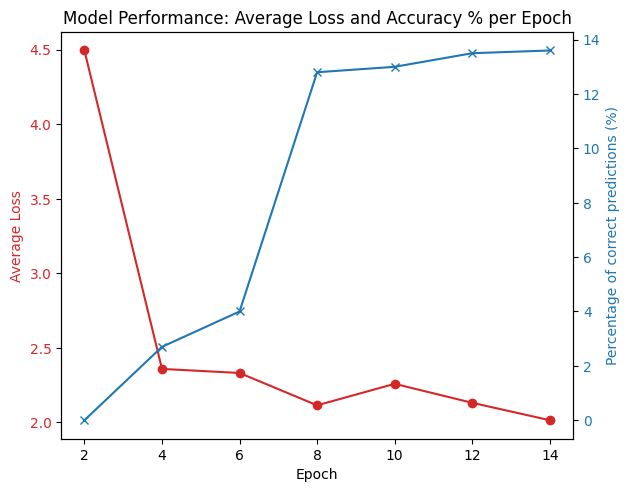

In [20]:
import pandas as pd  
import matplotlib.pyplot as plt  
  
# Load the epoch summary results from the CSV file  
df_summary = pd.read_csv('epoch_summary_results.csv')  
  
# Plotting both Average Loss and Accuracy on the same graph with dual y-axes  
fig, ax1 = plt.subplots()  
  
color = 'tab:red'  
ax1.set_xlabel('Epoch')  
ax1.set_ylabel('Average Loss', color=color)  
ax1.plot(df_summary['Epoch'], df_summary['Average Loss'], color=color, marker='o', label='Average Loss')  
ax1.tick_params(axis='y', labelcolor=color)  

# Creating a second y-axis for the accuracy percentage  
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis  
color = 'tab:blue'  
ax2.set_ylabel('Percentage of correct predictions (%)', color=color)  
ax2.plot(df_summary['Epoch'], df_summary['Accuracy (%)'], color=color, marker='x', label='Percentage of correct predictions (%)')  
ax2.tick_params(axis='y', labelcolor=color)  
  
fig.tight_layout()  # to prevent the right y-label from being slightly clipped  
plt.title('Model Performance: Average Loss and Accuracy % per Epoch')   
plt.show() 


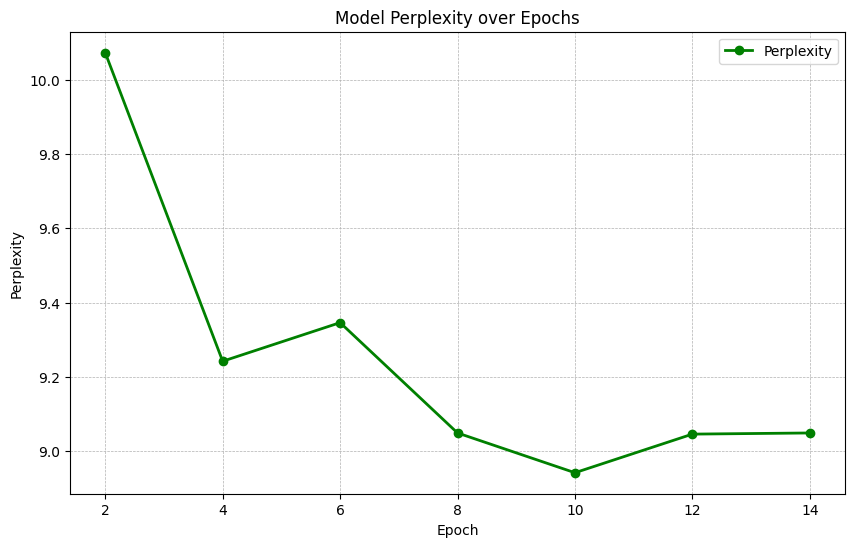

In [21]:

# Load the epoch summary results  
df = pd.read_csv('epoch_summary_results.csv')  
  
  
plt.figure(figsize=(10, 6))  # Set the figure size for the plot  
  
# Plotting Perplexity  
plt.plot(df['Epoch'], df['Perplexity'], color='green', marker='o', linestyle='-', linewidth=2, markersize=6, label='Perplexity')  
  
# Adding plot title and labels  
plt.title('Model Perplexity over Epochs')  
plt.xlabel('Epoch')  
plt.ylabel('Perplexity')  
  
# Adding a grid  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  
  
# Adding legend  
plt.legend()  
  
# Display the plot  
plt.show()  
 


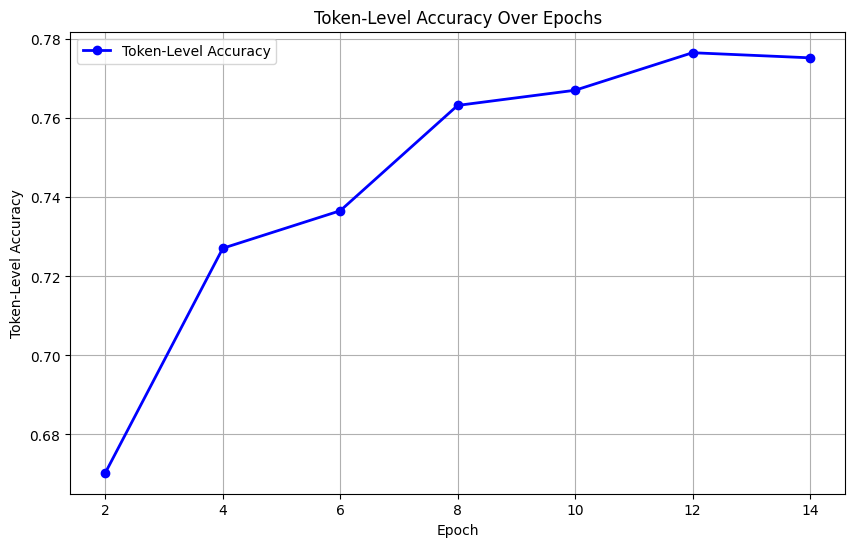

In [22]:
import matplotlib.pyplot as plt  
  
plt.figure(figsize=(10, 6))  # Set the figure size  
  
# Plotting the token-level accuracy  
plt.plot(df['Epoch'], df['Token-Level Accuracy'], color='blue', marker='o', linestyle='-', linewidth=2, markersize=6, label='Token-Level Accuracy')  
  
plt.title('Token-Level Accuracy Over Epochs')  # Title of the plot  
plt.xlabel('Epoch')  # X-axis label  
plt.ylabel('Token-Level Accuracy')  # Y-axis label  
plt.grid(True)  # Adding a grid  
plt.legend()  # Adding a legend  
  
plt.show()  # Display the plot  


In [38]:

def prepare_training_data_prompts(file_path, nlp_model, sample_size=None):  
    sentence_prompts_and_answers = []  
    with open(file_path, 'r', encoding='utf-8') as file:  
        for line in file:  
            doc = nlp_model(line.strip())  
            for sent in doc.sents:  
                words = sent.text.split()  
                if len(words) > 1:  # Ensure the sentence has at least 2 words  
                    prompt = " ".join(words[:-1]).strip()  
                    answer = words[-1].strip()  
                    sentence_prompts_and_answers.append((prompt, answer))  
                    if sample_size and len(sentence_prompts_and_answers) >= sample_size:  
                        return sentence_prompts_and_answers  
    return sentence_prompts_and_answers  
  
file_path = 'wikipedia_subset_cleaned.txt'  
training_data_prompts_and_answers = prepare_training_data_prompts(file_path, nlp, sample_size=100)  


In [39]:
def reinitialize_model():  
    # Your model initialization logic  
    return GPT(vocab_size=60000, embed_size=128, num_layers=6, heads=8, forward_expansion=4, dropout=0.1, max_length=1024)  

In [40]:
def evaluate_sentences_and_record(model, tokenizer, sentence_prompts_and_answers, detailed_csv_writer, epoch):  
    model.eval()  
    correct_predictions = 0  

In [ ]:
import torch  
import torch.optim as optim  
import csv  
  
  
epochs_list = [2, 4, 6, 8]  
  
  
# Open CSV files for writing detailed predictions and epoch summaries  
with open('training_data_detailed_evaluation_results.csv', mode='w', newline='', encoding='utf-8') as detailed_file, \
     open('training_data_epoch_summary_results.csv', mode='w', newline='', encoding='utf-8') as summary_file:  
        
    detailed_csv_writer = csv.writer(detailed_file)  
    detailed_csv_writer.writerow(['Epoch', 'Sentence', 'Right Word', 'Predicted Word', 'Correct?'])  
        
    summary_csv_writer = csv.writer(summary_file)  
    summary_csv_writer.writerow(['Epoch', 'Average Loss', 'Accuracy (%)', 'Perplexity','Token-Level Accuracy'])  
        
    max_epoch = max(epochs_list)  # Calculate the maximum epoch to train up to  
    model = reinitialize_model().to(device)  # Initialize  model   
    optimizer = optim.Adam(model.parameters(), lr=0.003)  # Initialize the optimizer  
      
    for epoch in range(1, max_epoch + 1):  
        model.train()  
        total_loss = 0  
    
        for input_ids, targets in dataloader:  # dataloader loop here  
            input_ids, targets = input_ids.to(device), targets.to(device)  
    
            optimizer.zero_grad()  
            output = model(input_ids)  
            loss = criterion(output.view(-1, model.vocab_size), targets.view(-1))  
            loss.backward()  
            optimizer.step()  
    
            total_loss += loss.item()  
    
        avg_loss = total_loss / len(dataloader)  
        print(f"Epoch {epoch}, Loss: {avg_loss:.4f}")  
    
        if epoch in epochs_list:  
            correct_predictions, total_predictions = evaluate_sentences_and_record(  
                model, tokenizer, training_data_prompts_and_answers, detailed_csv_writer, epoch)  
                
            accuracy = (correct_predictions / total_predictions) * 100  
            # Write epoch summary (average loss and accuracy)  

            perplexity_score = calculate_perplexity(model, dataloader, device)  # Use a separate validation dataloader if available  
            print(f"Epoch {epoch}, Perplexity: {perplexity_score:.2f}") 

            # After training, evaluate various metrics  
            token_level_accuracy = calculate_token_level_accuracy(model, dataloader, device)  
            print(f"Token Level Accuracy for epoch {epoch}: {accuracy}")  

            summary_csv_writer.writerow([epoch, avg_loss, accuracy, perplexity_score, token_level_accuracy])  
  


In [ ]:
import pandas as pd  
import matplotlib.pyplot as plt  
  
# Load the summary data  
df_summary = pd.read_csv('training_data_epoch_summary_results.csv')  
  
# Plotting  
fig, ax1 = plt.subplots(figsize=(10, 6))  
  
# Average Loss  
color = 'tab:red'  
ax1.set_xlabel('Epoch')  
ax1.set_ylabel('Average Loss', color=color)  
ax1.plot(df_summary['Epoch'], df_summary['Average Loss'], color=color, marker='o', linestyle='-', label='Average Loss')  
ax1.tick_params(axis='y', labelcolor=color)  
  
# Instantiate a second y-axis for the accuracy percentage  
ax2 = ax1.twinx()  
color = 'tab:blue'  
ax2.set_ylabel('Accuracy (%)', color=color)  
ax2.plot(df_summary['Epoch'], df_summary['Accuracy (%)'], color=color, marker='x', linestyle='-', label='Accuracy (%)')  
ax2.tick_params(axis='y', labelcolor=color)  
  
# Title and other customizations  
plt.title('Training Performance: Average Loss and Accuracy per Epoch for Training data')  
fig.tight_layout()  # Adjust layout to make room for the legend  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  
plt.show()  


In [ ]:
# Load the epoch summary results  
df = pd.read_csv('training_data_epoch_summary_results.csv')  
  
  
plt.figure(figsize=(10, 6))  # Set the figure size for the plot  
  
# Plotting Perplexity  
plt.plot(df['Epoch'], df['Perplexity'], color='green', marker='o', linestyle='-', linewidth=2, markersize=6, label='Perplexity')  
  
# Adding plot title and labels  
plt.title('Model Perplexity over Epochs for Training data')  
plt.xlabel('Epoch')  
plt.ylabel('Perplexity')  
  
# Adding a grid  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  
  
# Adding legend  
plt.legend()  
  
# Display the plot  
plt.show()  

In [ ]:
import matplotlib.pyplot as plt  
  
plt.figure(figsize=(10, 6))  # Set the figure size  
  
# Plotting the token-level accuracy  
plt.plot(df['Epoch'], df['Token-Level Accuracy'], color='blue', marker='o', linestyle='-', linewidth=2, markersize=6, label='Token-Level Accuracy')  
  
plt.title('Token-Level Accuracy Over Epochs')  # Title of the plot  
plt.xlabel('Epoch')  # X-axis label  
plt.ylabel('Token-Level Accuracy')  # Y-axis label  
plt.grid(True)  # Adding a grid  
plt.legend()  # Adding a legend  
  
plt.show()  # Display the plot  

In [44]:
import pandas as pd    
import torch    
import torch.optim as optim    
import torch.nn as nn    
import csv    
from torch.utils.data import DataLoader    
        

  
def evaluate_and_record(model, tokenizer, sentence_prompts_and_answers, csv_writer, num_layers):    
    model.eval()    
    device = next(model.parameters()).device    
    correct_predictions = 0    
    
    for prompt, expected_last_word in sentence_prompts_and_answers:    
        generated_text = generate_text_custom(model, tokenizer, prompt, max_length=50)  # Adjust max_length if necessary    
        generated_tokens = generated_text.strip().split()    
        predicted_last_word = generated_tokens[-1] if generated_tokens else ""    
            
        is_correct = int(predicted_last_word.lower() == expected_last_word.lower())    
        correct_predictions += is_correct    
    
        csv_writer.writerow([num_layers, prompt, expected_last_word, predicted_last_word, is_correct])    
          
    percentage_correct = (correct_predictions / len(sentence_prompts_and_answers)) * 100    
    print(f"Evaluation for models with {num_layers} layers completed. Percentage of Correct Predictions: {percentage_correct:.2f}%")    
  
# Define num_layers values to test    
num_layers_list = [2, 4, 8, 16, 32]    
  
# Open CSV file for writing results    
with open('layerwise_evaluation_results.csv', mode='w', newline='', encoding='utf-8') as file:    
    csv_writer = csv.writer(file)    
    csv_writer.writerow(['Num_Layers', 'Sentence', 'Right Word', 'Predicted Word', 'Correct?'])    
    
    for num_layers in num_layers_list:    
        model = GPT(vocab_size=60000, embed_size=128, num_layers=num_layers, heads=8, forward_expansion=4, dropout=0.1, max_length=1024).to(device)    
        optimizer = optim.Adam(model.parameters())    
        criterion = torch.nn.CrossEntropyLoss()    
  
        model.train()    
        for epoch in range(1):  # Train for 1 epoch for each num_layers configuration    
            total_loss = 0    
            for input_ids, targets in dataloader:  # Assuming dataloader is defined    
                input_ids, targets = input_ids.to(device), targets.to(device)    
                optimizer.zero_grad()    
                outputs = model(input_ids)    
                loss = criterion(outputs.view(-1, model.vocab_size), targets.view(-1))    
                loss.backward()    
                optimizer.step()    
                total_loss += loss.item()    
            print(f"Training Loss for {num_layers} layers: {total_loss / len(dataloader)}")    
    
        # Evaluation    
        evaluate_and_record(model, tokenizer, sentence_prompts_and_answers, csv_writer, num_layers)    


/tmp/ipykernel_4198/2817920276.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in input_ids],
/tmp/ipykernel_4198/2817920276.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_ids_padded = pad_sequence([torch.tensor(seq, dtype=torch.long) for seq in target_ids],


Input IDs Padded Shape: torch.Size([32, 220])
Target IDs Padded Shape: torch.Size([32, 220])
Input IDs Padded Shape: torch.Size([32, 266])
Target IDs Padded Shape: torch.Size([32, 266])
Input IDs Padded Shape: torch.Size([32, 232])
Target IDs Padded Shape: torch.Size([32, 232])
Input IDs Padded Shape: torch.Size([32, 285])
Target IDs Padded Shape: torch.Size([32, 285])
Input IDs Padded Shape: torch.Size([32, 245])
Target IDs Padded Shape: torch.Size([32, 245])
Input IDs Padded Shape: torch.Size([32, 382])
Target IDs Padded Shape: torch.Size([32, 382])
Input IDs Padded Shape: torch.Size([32, 251])
Target IDs Padded Shape: torch.Size([32, 251])
Input IDs Padded Shape: torch.Size([32, 209])
Target IDs Padded Shape: torch.Size([32, 209])
Input IDs Padded Shape: torch.Size([32, 283])
Target IDs Padded Shape: torch.Size([32, 283])
Input IDs Padded Shape: torch.Size([32, 217])
Target IDs Padded Shape: torch.Size([32, 217])
Input IDs Padded Shape: torch.Size([32, 274])
Target IDs Padded Shape:

In [ ]:
import pandas as pd  
import matplotlib.pyplot as plt  
  
# Load the CSV file into a DataFrame  
df = pd.read_csv('layerwise_evaluation_results.csv')  
  
# Calculate the percentage of correct predictions per epoch  
epoch_stats = df.groupby('Num_Layers').agg({'Correct?': ['sum', 'count']})  
  
correct_predictions = epoch_stats[('Correct?', 'sum')]  
total_predictions = epoch_stats[('Correct?', 'count')]  
  
# Calculate percentage of correct predictions  
percentage_correct = (correct_predictions / total_predictions) * 100  
  
# Plotting  
plt.figure(figsize=(10, 6))  # Set the figure size (optional)  
plt.plot(percentage_correct.index, percentage_correct.values, marker='o', linestyle='-', color='b')  
plt.title('Percentage of Correct Predictions per Number of Transformers %')  
plt.xlabel('Number of Transformers')  
plt.ylabel('Percentage of Correct Predictions')  
plt.xticks(percentage_correct.index)  # Ensure we have ticks for every epoch  
plt.grid(True, which='both', linestyle='--', linewidth=0.5)  # Adding a grid for easier reading  
  
# Display the plot  
plt.show()  


In [ ]:
import pandas as pd  
import torch.optim as optim  
  
  
# Define num_layers values to test  
num_layers_list = [2, 4, 8, 16, 32]  
  
# Open CSV file for writing results  
with open('layerwise_evaluation_results.csv', mode='w', newline='', encoding='utf-8') as file:  
    csv_writer = csv.writer(file)  
    csv_writer.writerow(['Num_Layers', 'Sentence', 'Right Word', 'Predicted Word', 'Correct?'])  
  
    for num_layers in num_layers_list:  
        # Initialize a new model with the current number of layers  
        model = GPT(vocab_size=60000, embed_size=128, num_layers=num_layers, heads=8, forward_expansion=4, dropout=0.1, max_length=1024).to(device)  
        optimizer = optim.Adam(model.parameters())  
        criterion = torch.nn.CrossEntropyLoss()  
  
        # Your training loop here, adjusted for the current model  
  
        # Evaluation  
        # Assuming you have a function to evaluate the model and record results  
        evaluate_and_record(model, tokenizer, sentence_prompts_and_answers, csv_writer, num_layers)  
